In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
file = "housing.csv"
housing = pd.read_csv(file)
housing_ = housing.copy()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0def3c2780>,
      dtype=object)

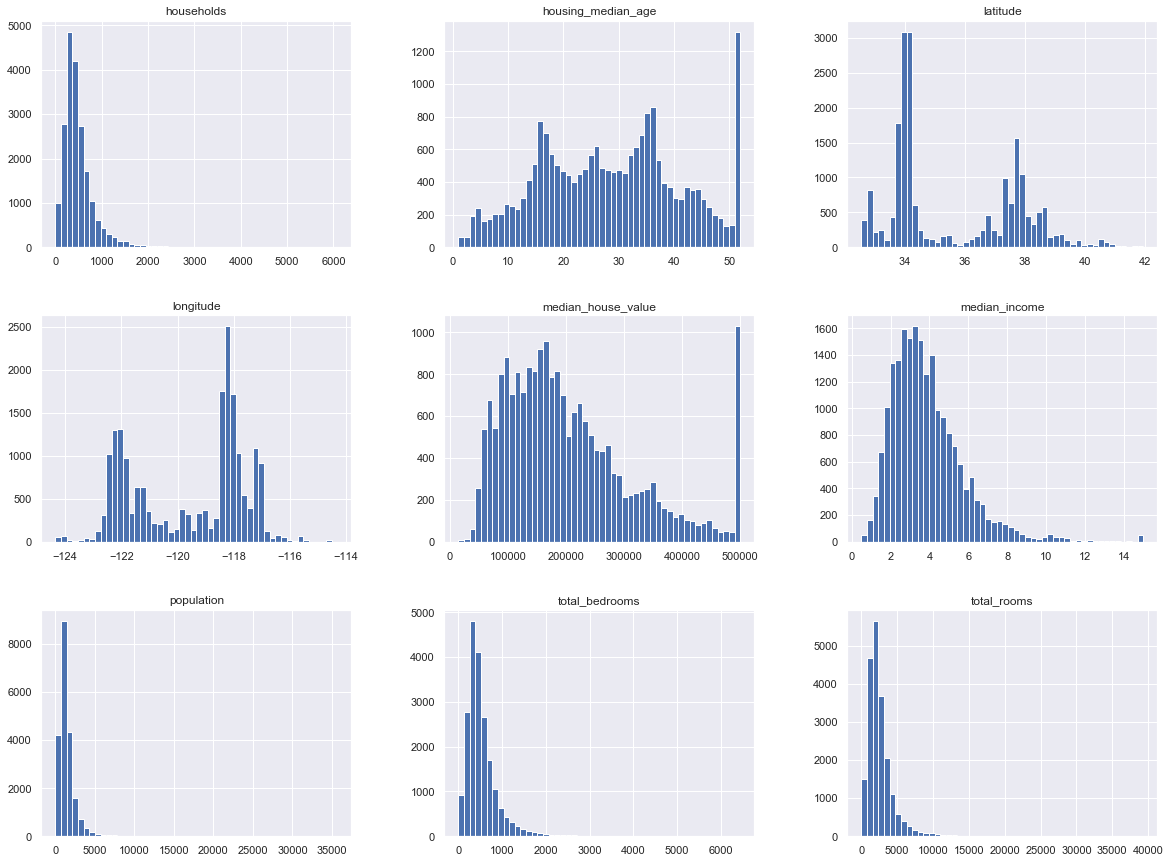

In [4]:
housing.hist(bins = 50, figsize=(20,15))


In [5]:
from sklearn.model_selection import train_test_split
X = housing.drop("median_house_value",axis = 1)
y = housing['median_house_value']
train_set,test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


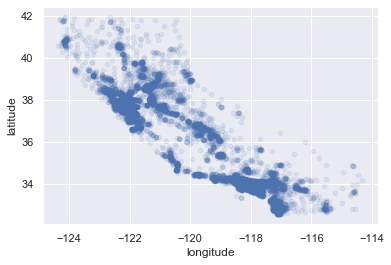

In [6]:
train_set.plot(kind='scatter', x='longitude', y='latitude', alpha = 0.1)

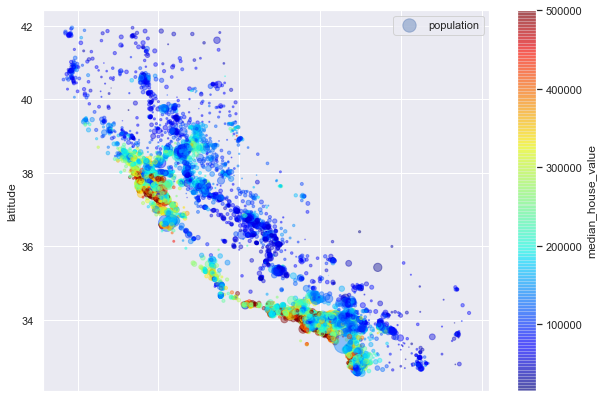

In [7]:
housing_train = train_set.copy()
housing_train.plot(kind = 'scatter', x='longitude', y='latitude', alpha = 0.4,\
            s = housing_train['population']/100, label = 'population',\
            figsize = (10,7), c='median_house_value', cmap = plt.get_cmap('jet'),\
                  colorbar = True)

#### Correlation

In [8]:
corr_matrix = housing_train.corr()

In [9]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
X = housing.drop("median_house_value",axis = 1)
y = housing['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [13]:
X_train_num = X_train.drop("ocean_proximity", axis=1)

In [14]:
from sklearn.compose import ColumnTransformer

num_attribs = list(X_train_num.columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])



In [15]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [16]:
y_train.isnull().sum()

0

#### Model

Linear regression

In [17]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
X_test_prepared = full_pipeline.fit_transform(X_test)

The $R^2$ is

In [19]:
lin_reg.score(X_test_prepared, y_test)

0.6145838467311528

The RMSE value:

In [20]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

71067.06604346124

This is better than nothing, but clearly not a great score. most district's median_house_vaue range between \\$120000  and \\$265000, so a prediction error of \\$71067 is not very  satisfying

This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough

he main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model

Decision Tree Regressor

In [21]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [22]:
tree_reg.score(X_train_prepared, y_train)

1.0

In [23]:
housing_predictions = tree_reg.predict(X_test_prepared)
tree_reg_mse = mean_squared_error(y_test, housing_predictions)
tree_reg_rmse = np.sqrt(tree_reg_mse)
tree_reg_rmse

104387.69702701522

This is the sample of overfitting model, where the score for the train set is near 100 % but the error for the test set is really high that is half of the range price

Evaluation with Cross-Validation

The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
scores = cross_val_score(tree_reg, X_train_prepared, y_train, 
                        scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [26]:
tree_rmse_scores

array([66036.82552165, 70873.45347897, 68261.40160916, 71510.48495026,
       73180.22453444, 67487.36080187, 65797.9904276 , 67713.50093414,
       65574.66573479, 71510.78227108])

In [27]:
def display_scores(scores):
...     print("Scores:", scores)
...     print("Mean:", scores.mean())
...     print("Standard deviation:", scores.std())

In [28]:
display_scores(tree_rmse_scores)

Scores: [66036.82552165 70873.45347897 68261.40160916 71510.48495026
 73180.22453444 67487.36080187 65797.9904276  67713.50093414
 65574.66573479 71510.78227108]
Mean: 68794.6690263969
Standard deviation: 2615.7967658014004


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Random Forest

Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further.

In [29]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_prepared, y_train)
forest_reg.score(X_train_prepared, y_train)

/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9627935488084121

In [30]:
scores = cross_val_score(forest_reg, X_train_prepared, y_train, 
                        scoring = 'r2', cv = 10)


In [31]:
display_scores(scores)

Scores: [0.82252282 0.7918223  0.79332804 0.77166839 0.77313416 0.81208706
 0.79703239 0.78368683 0.80249747 0.79555192]
Mean: 0.794333137920346
Standard deviation: 0.015063311722483912


Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set

Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

Before you dive much deeper into Random Forests, however, you should try out many other models from various categories of Machine Learning algorithms (e.g., several Support Vector Machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

### Fine-Tune the Model

Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

#### Grid Search

Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='r2',
                           return_train_score=True)

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first dict (don’t worry about what these hyperparameters mean for now; they will be explained in Chapter 7), then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, but this time with the bootstrap hyperparameter set to False instead of True (which is the default value for this hyperparameter).

In [33]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

###### Tip :
Since 8 and 30 are the maximum values that were evaluated, you should probably try searching again with higher values; the score may continue to improve.

In [34]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
cvres = grid_search.cv_results_
for r2, params in zip(cvres['mean_test_score'], cvres['params']):
    print(r2, params)

0.6918333495078953 {'max_features': 2, 'n_estimators': 3}
0.7710504607313261 {'max_features': 2, 'n_estimators': 10}
0.7948602292643264 {'max_features': 2, 'n_estimators': 30}
0.7315941948169606 {'max_features': 4, 'n_estimators': 3}
0.7917761861391042 {'max_features': 4, 'n_estimators': 10}
0.8139846188125353 {'max_features': 4, 'n_estimators': 30}
0.7421847312313704 {'max_features': 6, 'n_estimators': 3}
0.7990832656687128 {'max_features': 6, 'n_estimators': 10}
0.815275589778262 {'max_features': 6, 'n_estimators': 30}
0.7498930119635896 {'max_features': 8, 'n_estimators': 3}
0.7959874982109598 {'max_features': 8, 'n_estimators': 10}
0.8154004330335368 {'max_features': 8, 'n_estimators': 30}
0.7207539063355902 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.7840751574607684 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.7298298544733302 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.7919969339340719 {'bootstrap': False, 'max_features': 3, 'n_

In [36]:
optimum_randomforest = grid_search.best_estimator_
scores_opt = cross_val_score(optimum_randomforest, X_train_prepared, y_train, 
                        scoring = 'r2', cv = 5)

In [37]:
display_scores(scores_opt)

Scores: [0.81941304 0.8015849  0.818909   0.81773724 0.81351732]
Mean: 0.8142323012038819
Standard deviation: 0.006655284228226257


#### Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead.

it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefit

#### Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [38]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.41291517e-02, 6.03739889e-02, 4.33532096e-02, 1.50809312e-02,
       1.48131125e-02, 1.56978397e-02, 1.30077868e-02, 3.68327299e-01,
       5.05383915e-02, 1.10912005e-01, 6.96718718e-02, 5.91554294e-03,
       1.62516484e-01, 2.19654269e-04, 2.07700741e-03, 3.36572428e-03])

In [42]:
params = [{'kernel' : ['linear'], 'C' : [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}]

In [45]:
from sklearn.svm import SVR

In [46]:
from sklearn.model_selection import GridSearchCV
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   4.9s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   5.0s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   5.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.2s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.2s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  10.3s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  10.6s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.4s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.4s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.4s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.3s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.4s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.3s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.3s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   9.6s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   9.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   9.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   9.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   9.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   9.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   9.9s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 41.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=2)

In [48]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [49]:
grid_search.best_estimator_

SVR(C=30000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [53]:
grid_search.best_score_

0.6438354987562639

In [52]:
opt_svr = grid_search.best_estimator_